# FCT Unesp - TCC Treino 3v2
Aluno: Pétrus Antonio Bárbosa Pradella

TCC2 - Treinando análise preditiva para dados de transações comerciais.

Teste 3v2
    - DataSet Utilizado: Shanpoo Sales
    - Fonte: Makridakis, Wheelwright and Hyndman (1998).
    - Link: https://machinelearningmastery.com/time-series-datasets-for-machine-learning/
    
    Dataset disponibilizado no livro "Forecasting (3rd Ed.) Hardcover – 16 Jan 1998" de 1998
    
Caracteristicas gerais do Dataset:

    - Número de Instancias: 9994
    - Número de Atributos: 2

### Importando as bibliotecas necessárias

In [1]:
from myownapi.MainAPI import MainAPI;
import matplotlib.pyplot as plt;

### Carregando a base de dados

In [2]:
onlineMode = False;

if onlineMode:
    dataset_folder_url = "http://downloads.finalcraft.com.br/tcc/TimeSeries";
else:
    dataset_folder_url = "C:/Users/Petrus/Desktop/UNESP/Docs 2016-2020/2019/Segundo Semestre/TCC2/TCC BigData Analytics/Treino3";

dataset_file = dataset_folder_url + '/shampoo.csv';

dataFrame = MainAPI.read_csv(dataset_file);
print("\n\n")
print(dataFrame)

Iniciando leitura do arquivo:
 --> C:/Users/Petrus/Desktop/UNESP/Docs 2016-2020/2019/Segundo Semestre/TCC2/TCC BigData Analytics/Treino3/shampoo.csv
Arquivo lido com sucesso!



          Date  Sales
0   2016-01-01  266.0
1   2016-02-01  145.9
2   2016-03-01  183.1
3   2016-04-01  119.3
4   2016-05-01  180.3
5   2016-06-01  168.5
6   2016-07-01  231.8
7   2016-08-01  224.5
8   2016-09-01  192.8
9   2016-10-01  122.9
10  2016-11-01  336.5
11  2016-12-01  185.9
12  2017-01-01  194.3
13  2017-02-01  149.5
14  2017-03-01  210.1
15  2017-04-01  273.3
16  2017-05-01  191.4
17  2017-06-01  287.0
18  2017-07-01  226.0
19  2017-08-01  303.6
20  2017-09-01  289.9
21  2017-10-01  421.6
22  2017-11-01  264.5
23  2017-12-01  342.3
24  2018-01-01  339.7
25  2018-02-01  440.4
26  2018-03-01  315.9
27  2018-04-01  439.3
28  2018-05-01  401.3
29  2018-06-01  437.4
30  2018-07-01  575.5
31  2018-08-01  407.6
32  2018-09-01  682.0
33  2018-10-01  475.3
34  2018-11-01  581.3
35  2018-12-01  646.9


### Descrevendo o DataFrame

In [3]:
MainAPI.descreverDataFrame()

,Date,Sales
count,36,36.000000
unique,36,NaN
top,2018-10-01,NaN
freq,1,NaN
mean,NaN,312.600000
std,NaN,148.937164
min,NaN,119.300000
20%,NaN,185.900000
40%,NaN,231.800000
50%,NaN,280.150000


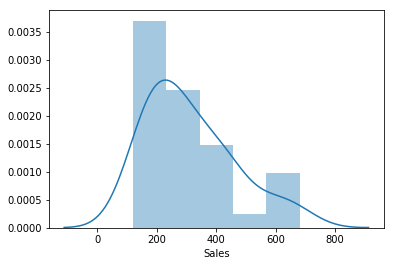

In [4]:
MainAPI.plotar('Sales')

### Selecionando dados 

In [5]:
import pandas as pd;

#É necessário converter de "String" para dateTime
dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])

dataFrame = MainAPI.df.groupby('Date')['Sales'].sum().reset_index()
dataFrame = dataFrame.set_index('Date')
dataFrame.head(3)

,Sales
Date,
2016-01-01,266.0
2016-02-01,145.9
2016-03-01,183.1


### Visualização dos Dados

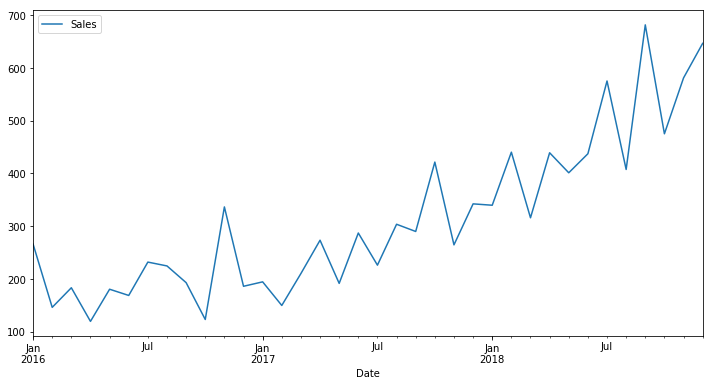

In [6]:
dataFrame.plot(figsize = (12,6))
plt.show()

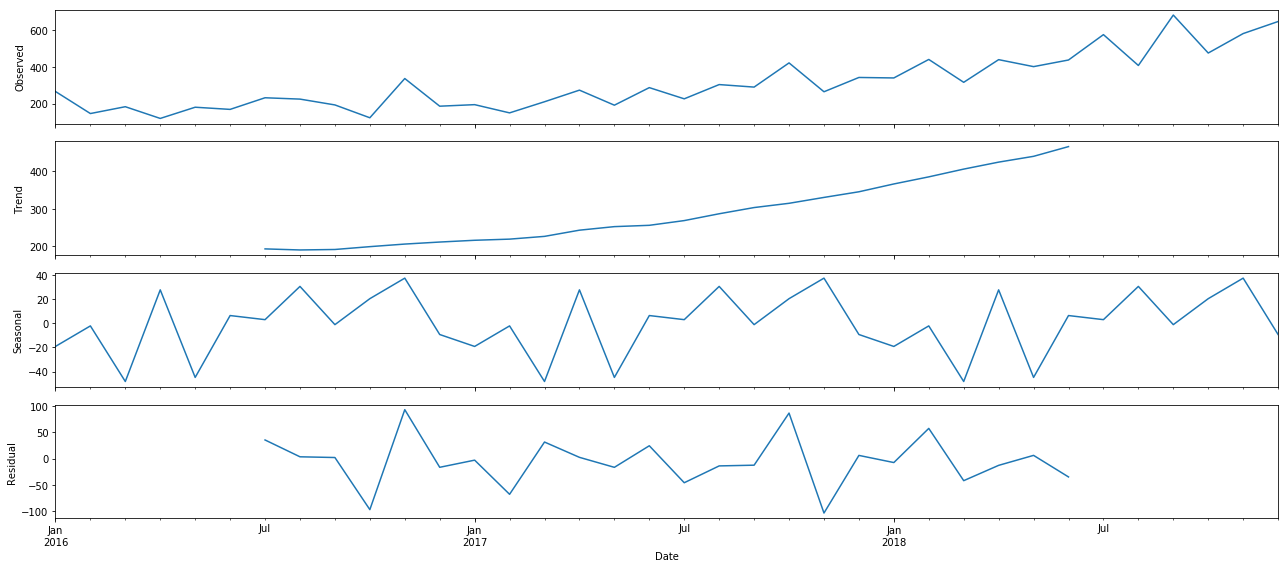

In [7]:
from pylab import rcParams;
import statsmodels.api as sm;

rcParams['figure.figsize'] = 18,8;

#Dois tipos de modelos possíves, Aditivo e Multiplicativo (Necessário testar as diferenças)
decomposicao = sm.tsa.seasonal_decompose(dataFrame, model='addtive')
decomposicao.plot();


### Arima Predction


#### Preparando quantidade de treino.

In [8]:
import itertools;

p = sazonalidade = range(0, 2);     # Arima P == auto-regressive part of the model
d = tendencia = range(0, 2);        # Arima D == integrated part of the model
q = ruido = range(0,2);             # Arima Q == moving average part of the model

#itertools.product basicamente relaciona todas as variáveis com todas as varíaveis... como já diz, PRODUCT
pdq = list(itertools.product(sazonalidade, tendencia, ruido))

#Criando agora as variações de calculos para o arima usar.
#(Similar ao 'grid search' de machine learning)
ARIMA_SASONALIDADE = 12; #12 meses, no caso, 1 ano;
seasonal_pdq = [(x[0], x[1], x[2], ARIMA_SASONALIDADE) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

#### Escolhendo melhor combinação de parametros arima

In [9]:
import warnings;
import sys;
warnings.filterwarnings("ignore") # Negócio chato pacas...

menorCombinacao = None;
menorCombinacaoValor = 99999999999999999;#Mesma coisa que Integer.MAX_VALUE

for parametro in pdq:
    for parametro_sasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataFrame,
                                            order=parametro,
                                            seasonal_order=parametro_sasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            resultado = mod.fit()
            
            if resultado.aic < menorCombinacaoValor:
                menorCombinacao = [parametro, parametro_sasonal, ARIMA_SASONALIDADE];
                menorCombinacaoValor = resultado.aic;
            
            print('ARIMA{}x{}x{} - AIC:{}'.format(parametro, parametro_sasonal, ARIMA_SASONALIDADE, resultado.aic))
        except:
            #Algumas combinações são NaN (Não são possíveis! por isso tem esse TryCath)
            continue
          
print('\n\n')
print('O menor valor encontrado par ao AIC é: {}'.format(menorCombinacaoValor))
print('Utilizando a combinação: ARIMA{}x{}x{}'.format(menorCombinacao[0], menorCombinacao[1], menorCombinacao[2]))

theOrder = menorCombinacao[0];
theSeasonal_order = menorCombinacao[1];

ARIMA(0, 0, 0)x(0, 0, 0, 12)x12 - AIC:510.854623413777
ARIMA(0, 0, 0)x(0, 1, 0, 12)x12 - AIC:309.63269589021763
ARIMA(0, 0, 0)x(1, 0, 0, 12)x12 - AIC:308.6195871380475
ARIMA(0, 0, 0)x(1, 1, 0, 12)x12 - AIC:168.03590486547643
ARIMA(0, 0, 1)x(0, 0, 0, 12)x12 - AIC:473.2974965989219
ARIMA(0, 0, 1)x(0, 1, 0, 12)x12 - AIC:295.9887325310341
ARIMA(0, 0, 1)x(1, 0, 0, 12)x12 - AIC:308.4922500040485
ARIMA(0, 0, 1)x(1, 1, 0, 12)x12 - AIC:168.85426642301758
ARIMA(0, 1, 0)x(0, 0, 0, 12)x12 - AIC:416.7902174442237
ARIMA(0, 1, 0)x(0, 1, 0, 12)x12 - AIC:293.5467216714689
ARIMA(0, 1, 0)x(1, 0, 0, 12)x12 - AIC:280.793120529793
ARIMA(0, 1, 0)x(1, 1, 0, 12)x12 - AIC:147.25150621264447
ARIMA(0, 1, 1)x(0, 0, 0, 12)x12 - AIC:389.7336859116634
ARIMA(0, 1, 1)x(0, 1, 0, 12)x12 - AIC:266.7204962865358
ARIMA(0, 1, 1)x(1, 0, 0, 12)x12 - AIC:275.20666867495174
ARIMA(0, 1, 1)x(1, 1, 0, 12)x12 - AIC:141.38700258488493
ARIMA(1, 0, 0)x(0, 0, 0, 12)x12 - AIC:431.20735801166643
ARIMA(1, 0, 0)x(0, 1, 0, 12)x12 - AIC:303.2

#### Ajuste de Modelo

In [10]:
mod = sm.tsa.statespace.SARIMAX(dataFrame,
                                order=theOrder,
                                seasonal_order=theSeasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

resultado_final = mod.fit()

print(resultado_final.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7310      0.404     -1.810      0.070      -1.523       0.061
ma.L1         -0.5124      0.750     -0.683      0.495      -1.983       0.958
ar.S.L12      -0.3871      0.448     -0.864      0.388      -1.265       0.491
sigma2      6143.4562   4102.589      1.497      0.134   -1897.470    1.42e+04


### Forecast dos dados em modo de treino

In [11]:
import pandas as pd;

#Predição propriamente dita
pred = resultado_final.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

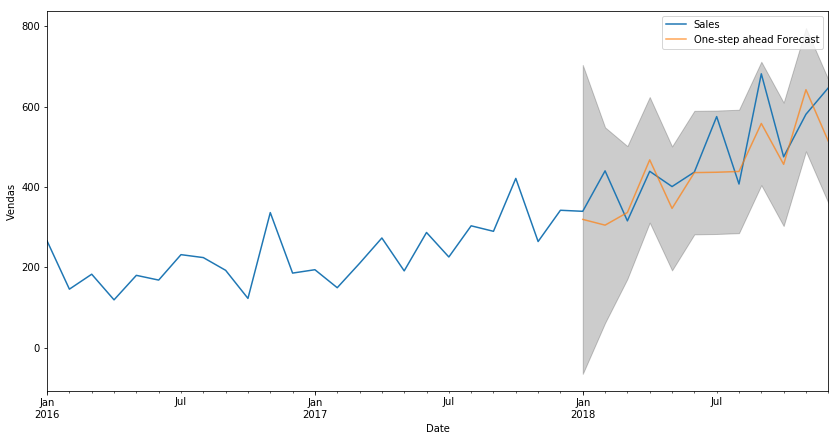

In [12]:
import matplotlib.pyplot as plt

ax = dataFrame['2016':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()


### Real Forecast

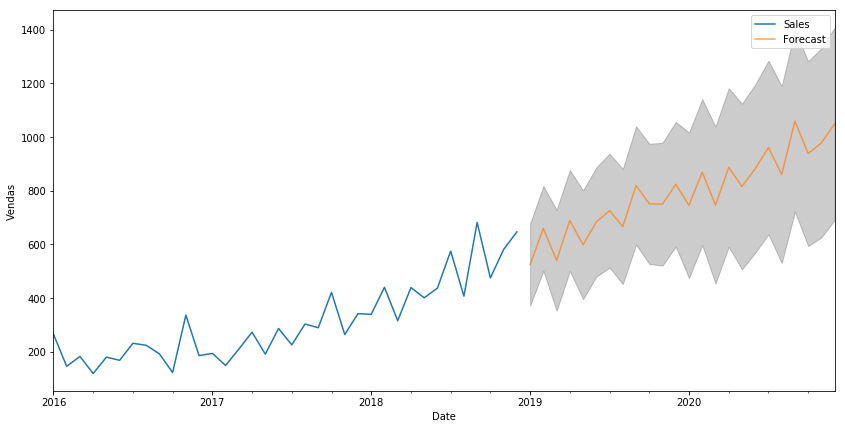

In [13]:
pred_uc = resultado_final.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()

ax = dataFrame['2016':].plot(label='Observado')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()